In [3]:
%load_ext autoreload 
%autoreload 2
%cd ../

/Users/ciarapatterson/Documents/code/who-can-social-distance


In [32]:

import src.models.test_and_train_model as mod
import src.visualization.visualize as viz
from src.data.make_dataset import CountiesWithPolicies, get_nyt_case_data

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.dates as mdates 
import matplotlib.pyplot as plt 
import seaborn as sns

import pandas as pd 
pd.options.mode.chained_assignment = None # default = "True"


Our exploratory data analysis revealed that our dataset has a high degree of multicollinearity. While multicollinearity will not affect the accuracy of the regression model, it will make it more difficult to interpret our results. 

Decision trees can be especially robust to multicollinearity. A simple decision tree learns to predict a target value by continuously splitting the data at each node in the tree. At each split, the tree iterates through the features and selects the one that most significantly reduce the split-criterion. Building the decision tree is a greedy process since at each split, the algorithm makes the optimal choice to reduce the error function, and that greedy process, in turn, makes trees especially robust to multicollinearity.

However, trees can easily become overfit. To avoid overfitting, we'll use an ensemble decision tree model -- a random forest regression model -- with both bootstrapping and feature sub-sampling.

In [26]:
# load county features dataset 
counties = CountiesWithPolicies(load = True)
counties.dataset.head(2)

,telework_score,percent_freq_or_always_mask_use,percent_republican_2016_pres,population_total,percent_uninsured,percent_below_poverty_line,percent_households_more_people_than_rooms,percent_racial_minority,percent_without_high_school_diploma,percent_over_65,...,median_non_home_dwell_time_percent_increase_jan_to_april,median_percentage_time_home_percent_increase_jan_to_april,percentage_completely_home_percent_increase_jan_to_april,start_date,end_date,num_days,starting_cases_100k,ending_cases_100k,net_cases,avg_new_cases
6001,0.412083,0.918,0.146610,1643700,5.1,10.6,7.7,68.2,12.0,13.1,...,-8150.757576,19.965952,45.807196,2020-04-19,2021-01-30,286,71.53,4440.19,4368.66,15.275035
6003,0.318770,0.802,0.360465,1146,10.3,19.8,2.3,40.8,11.1,25.6,...,-808.651399,36.285409,56.865238,2020-07-05,2021-01-30,209,96.25,6929.74,6833.49,32.696124


In [33]:
feature_names = [
    'start_date',
    'telework_score',
    'percent_freq_or_always_mask_use',
    'percent_republican_2016_pres',
    'percent_uninsured',
    'percent_below_poverty_line',
    'percent_households_more_people_than_rooms',
    'percent_racial_minority',
    'percent_without_high_school_diploma',
    'percent_over_65',
    'population_density',
    'median_non_home_dwell_time_percent_increase_jan_to_april'
]
results_col = 'avg_new_cases'

features = counties.dataset[feature_names]

# convert start date to int64 to allow it be ingested by model
features['start_date'] = features['start_date'].astype('int64')

# remove nulls and create a features matrix and results array
features = features.dropna()
results = counties.dataset.dropna()[results_col]

In [34]:
# use GridSearchCV to determine optimal variables for Random Forest
reg = RandomForestRegressor()

X_train, X_test, y_train, y_test = train_test_split(features, results, test_size = 0.3, random_state = 42)

# set of possible parameters 
params = {
    'max_depth':[70, 80, 90, 100],
    'n_estimators':[900, 1000, 1100]
}

gridforest = GridSearchCV(reg, params, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 90, 'n_estimators': 1000}

In [36]:
pred_df, feature_importance = mod.build_rand_forest_reg(features, results, scale_test_data = False, estimators = 1000, max_depth = 90)

Test size (108,)

---
FEATURE IMPORTANCE 
---

start_date           Importance: 0.40773656913809736
percent_racial_minority Importance: 0.16489164361521946
percent_households_more_people_than_rooms Importance: 0.13366331116839397
percent_without_high_school_diploma Importance: 0.09019586982179117
percent_over_65      Importance: 0.04664150161460816
population_density   Importance: 0.03179517375846558
percent_uninsured    Importance: 0.02921999962371952
percent_below_poverty_line Importance: 0.024994002168897318
percent_freq_or_always_mask_use Importance: 0.021962344984388434
median_non_home_dwell_time_percent_increase_jan_to_april Importance: 0.01875809362275386
telework_score       Importance: 0.015956315516070626
percent_republican_2016_pres Importance: 0.01418517496759476

---
MODEL SCORES 
---

R^2 Training Score: 0.95 
OOB Score: 0.65 
R^2 Validation Score: 0.63

---
MODEL ERROR 
---

Mean Absolute Error: 4.7938132777725
Mean Squared Error: 49.04984863972055
Root Mean Squared Erro

Our model is currently explaining ~63% of the variance in the average number of new COVID-19 cases observed each day that a policy is in place and has a relatively small absolute error. Currently, start date is the most important predictor of average new COVID-19 cases. However, this result is potentially uninteresting. We know that start date is a strong predictor of COVID-19 cases because there were far more cases during the fall of 2020 than there were at any other point in the year.   

In [ ]:
get_nyt_case_data()

(array([18383., 18414., 18444., 18475., 18506., 18536., 18567., 18597.,
        18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

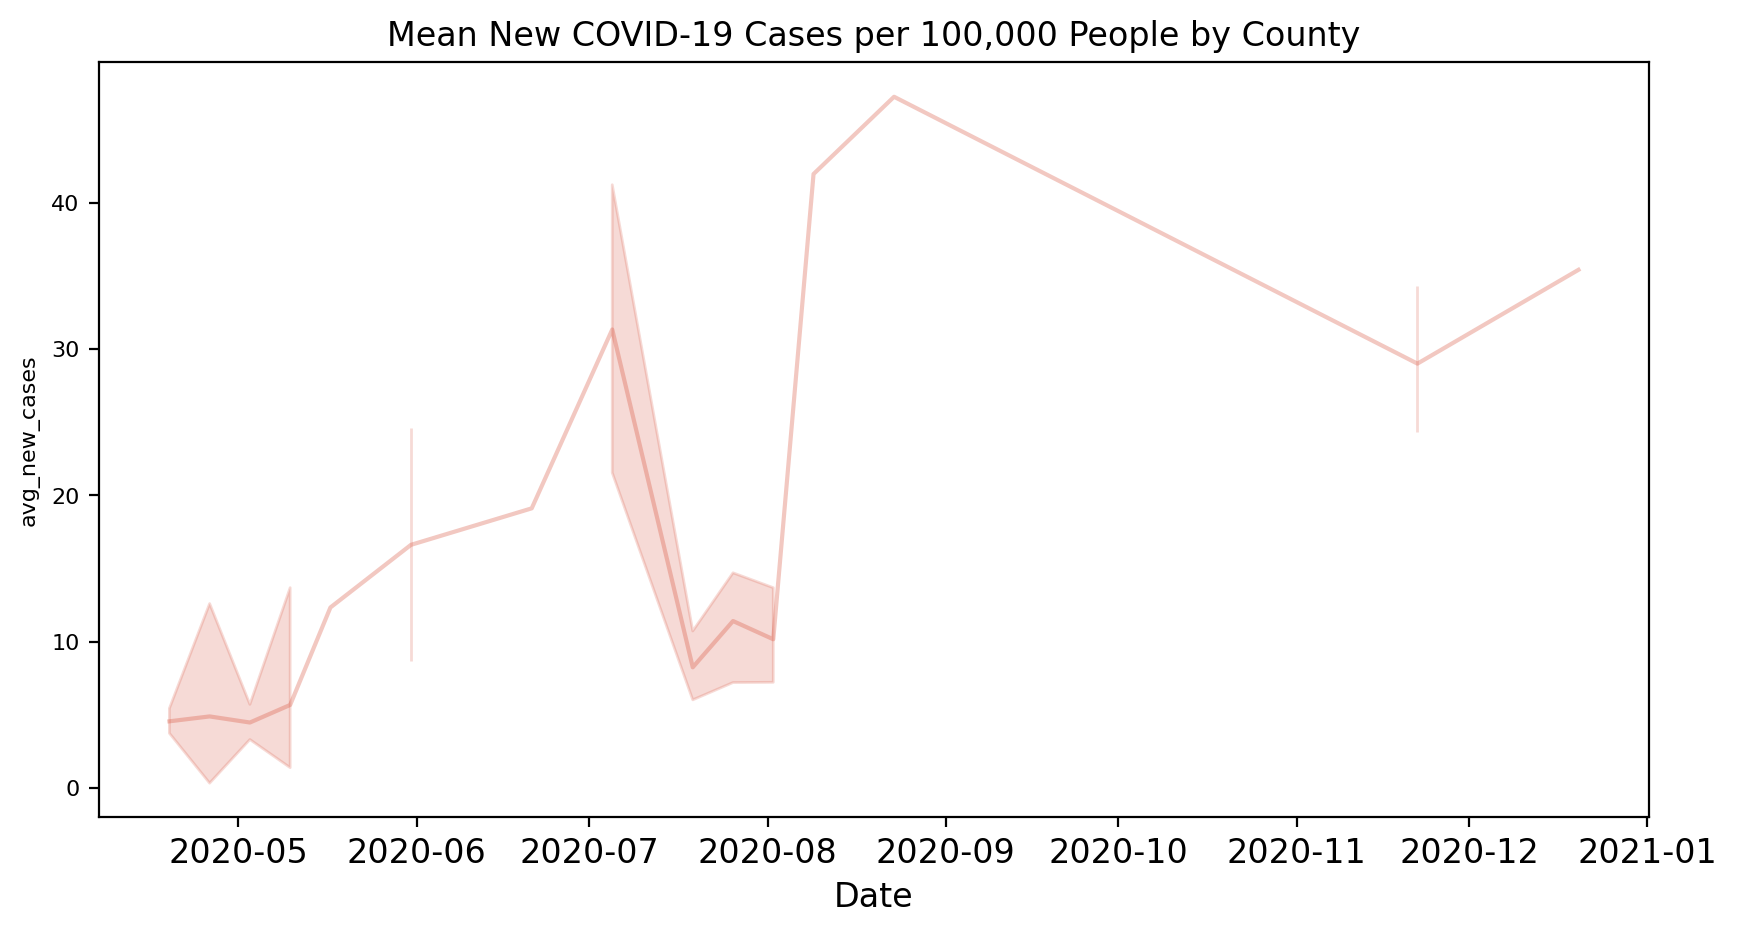

In [44]:
plt.rcParams.update({'font.size':8})
plt.figure(figsize = (10, 5))

cols = ['start_date', 'avg_new_cases']
sns.lineplot(x = 'start_date', y = 'avg_new_cases', data = counties.dataset.dropna()[cols], color = '#D64933', legend = False, alpha = .3)
plt.title('Mean New COVID-19 Cases per 100,000 People by County', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.xticks(fontsize = 12)

In [42]:
counties.dataset[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 6001 to 53077
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   start_date     360 non-null    datetime64[ns]
 1   avg_new_cases  360 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.4 KB
